In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!wget https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-5287/ud-treebanks-v2.13.tgz

--2024-02-25 06:38:39--  https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-5287/ud-treebanks-v2.13.tgz
Resolving lindat.mff.cuni.cz (lindat.mff.cuni.cz)... 195.113.20.140
Connecting to lindat.mff.cuni.cz (lindat.mff.cuni.cz)|195.113.20.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 538578674 (514M) [application/x-gzip]
Saving to: 'ud-treebanks-v2.13.tgz'

ud-treebanks-v2.13. 100%[===================>] 513.63M  19.7MB/s    in 27s     

2024-02-25 06:39:08 (19.1 MB/s) - 'ud-treebanks-v2.13.tgz' saved [538578674/538578674]



***Installing Conllu library to work with conluu dataset for POS tagging and rest of imports***

In [3]:
!pip install conllu

In [4]:
from conllu import parse,parse_incr
import io
import torch
from torch import nn,tensor
from torch.utils.data import Dataset,DataLoader
from torchtext.vocab import build_vocab_from_iterator
from tqdm import tqdm
import re

In [5]:
import wandb

In [6]:
wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
wandb.init(project='nlpa23')

wandb: Currently logged in as: anshulsharma2323 (ttm-me). Use `wandb login --relogin` to force relogin


In [8]:
device='cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
import tarfile
file=tarfile.open('/kaggle/working/ud-treebanks-v2.13.tgz')
file.extractall('./ud-treebanks')

In [10]:
!ls './ud-treebanks/ud-treebanks-v2.13/UD_English-Atis/'

LICENSE.txt	       en_atis-ud-dev.txt      en_atis-ud-train.conllu
README.md	       en_atis-ud-test.conllu  en_atis-ud-train.txt
en_atis-ud-dev.conllu  en_atis-ud-test.txt     stats.xml


In [11]:
all_files_loc=[f'./ud-treebanks/ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-{i}.conllu' for i in ['train','test','dev']]

In [12]:
all_files_loc

['./ud-treebanks/ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-train.conllu',
 './ud-treebanks/ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-test.conllu',
 './ud-treebanks/ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-dev.conllu']

In [13]:
from pprint import pprint

In [14]:
tok=[]
mxlen=[]
labels=[]
file_opened_path_train=io.open(all_files_loc[0])
for x in parse_incr(file_opened_path_train):
    mxlen.append(len(x))
    #break
    if len(x)==0:
        continue
    for y in x:
        #print(y)
        #if x =='=':continue
        tok+=[[y['form'].lower()]]
        #tok+=[[y['upos']]]
        labels+=[[y['upos']]]
        
vocab_data=build_vocab_from_iterator(tok,min_freq=1,specials=['<PAD>','<UNK>','<EOS>','<SOS>'])
vocab_data.set_default_index(vocab_data.get_stoi()['<PAD>'])  
vocab_labels=build_vocab_from_iterator(labels,min_freq=1,specials=['<PAD>'])
vocab_labels.set_default_index(vocab_labels.get_stoi()['<PAD>'])

In [15]:
lst=[]
for i in labels:
    lst.append(i[0])

In [16]:
toke=[i[0] for i in tok]

In [17]:
len(set(toke))

863

In [18]:
len(set(lst))

13

In [19]:
file_opened_path_train=io.open(all_files_loc[0])
z=[]
for x in parse_incr(file_opened_path_train):
    z.append(x)
    break

In [20]:
z[0][0]

{'id': 1,
 'form': 'what',
 'lemma': 'what',
 'upos': 'PRON',
 'xpos': None,
 'feats': {'PronType': 'Int,Rel'},
 'head': 0,
 'deprel': 'root',
 'deps': None,
 'misc': None}

In [21]:
for x in z:
    print(x)

TokenList<what, is, the, cost, of, a, round, trip, flight, from, pittsburgh, to, atlanta, beginning, on, april, twenty, fifth, and, returning, on, may, sixth, metadata={sent_id: "0001.train", text: "what is the cost of a round trip flight from pittsburgh to atlanta beginning on april twenty fifth and returning on may sixth"}>


**Doing Length Analysis**

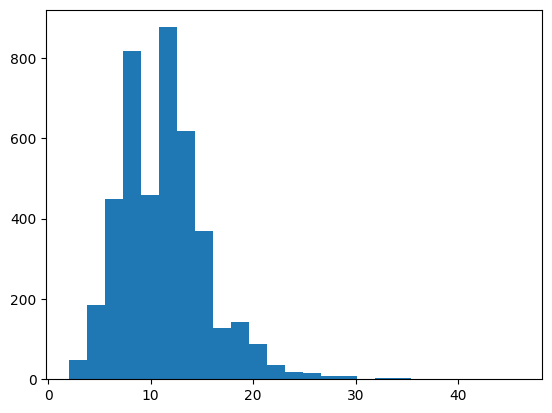

In [22]:
import matplotlib.pyplot as plt
z=plt.hist(mxlen,bins=25)

In [23]:
## set mxlen as 24

**Creating Dataset and Dataloader**

In [24]:
class Datafetch(Dataset):
    def __init__(self,type_of_data):
        data=[]
        labels=[]
        for x in tqdm(parse_incr(io.open(type_of_data)),desc='Generate words and tokens'):
            if len(x)<4 :continue
            indices=[vocab_data[y['form']] if vocab_data[y['form']]!=None else vocab_data['<UNK>'] for y in x ]
            final_labels=[vocab_labels[y['upos']] for y in x]
            if len(indices)>24:
                indices=indices[:24]
                final_labels=final_labels[:24]
            elif len(indices)<24:
                indices=indices+(24-len(indices))*[vocab_data['<PAD>']]
                final_labels=final_labels+(24-len(final_labels))*[vocab_labels['<PAD>']]
            data.append(indices)
            labels.append(final_labels)
        self.data=tensor(data)
        self.labels=tensor(labels)
    def __len__(self)->int:
        return len(self.data)
    def __getitem__(self,index:int):
        return self.data[index],self.labels[index]
            
        
        

In [25]:
train_datafetch=Datafetch(all_files_loc[0])

Generate words and tokens: 4274it [00:00, 4548.09it/s]


In [26]:
train_dataloader=DataLoader(train_datafetch,batch_size=64,shuffle=True,pin_memory=True)

In [27]:
dev_datafetch=Datafetch(all_files_loc[1])
dev_dataloader=DataLoader(dev_datafetch,batch_size=64,shuffle=True,pin_memory=True)

Generate words and tokens: 586it [00:00, 4608.97it/s]


In [28]:
test_datafetch=Datafetch(all_files_loc[2])
test_dataloader=DataLoader(test_datafetch,batch_size=64,shuffle=True,pin_memory=True)

Generate words and tokens: 572it [00:00, 4373.32it/s]


**Using 1st type Model as bidirectional LSTM**

In [30]:
class LSTM1(torch.nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,output_labels_size):
        super(LSTM1,self).__init__()
        self.embedding=nn.Embedding(vocab_size,embedding_dim,padding_idx=0)
        self.embedding.weight.requires_grad=True
        self.lstm=nn.LSTM(embedding_dim,hidden_dim,num_layers=2,bidirectional=True,batch_first=True)
        #self.linear1=nn.Linear(hidden_dim*2,out_features=384)
        self.linear2=nn.Linear(hidden_dim*2,output_labels_size)
        #self.lrelu=nn.LeakyReLU()
    def forward(self,id_data):
        x=self.embedding(id_data)
        x,(o_t,y_t)=self.lstm(x)
        #x=self.lrelu(self.linear1(x))
        x=self.linear2(x)
        return x

In [31]:
def train_eval_loopwowandb(model,learning_rate,epochs,embedding_dim,hidden_units):
    model=model(len(vocab_data),embedding_dim,hidden_units,len(vocab_labels))
    model.to(device)
    optimizer=torch.optim.Adam(model.parameters(),learning_rate)
    loss_fn=torch.nn.CrossEntropyLoss()
    #wandb.watch(model,loss_fn,log="all")
    train_epoch_acc=[]
    dev_epoch_acc=[]
    running_loss_train=[]
    running_loss_dev=[]
    for i in range(epochs):
        model.train()
        train_correct=0
        dev_correct=0
        total_samples_train=0
        total_samples_dev=0
        running_loss=0.0
        acc_t=0
        acc_d=0
        for batch in tqdm(train_dataloader,desc='training'):
            d,l=batch
            optimizer.zero_grad()
            pred=model(d.to(device))
            loss=loss_fn(pred.view(-1,pred.size(2)),l.view(-1).to(device))
            loss.backward()
            optimizer.step()
            _,pred_indices=torch.max(pred,2)
            train_correct+=(pred_indices.view(-1)==l.view(-1).to(device)).sum().item()
            total_samples_train+= l.size(0)*l.size(1)
            running_loss+=loss.item()
            #    wandb.log({'epoch':i+1,'loss':running_loss})
        acc_t=100*train_correct/total_samples_train
        running_loss_train.append(running_loss)
        train_epoch_acc.append(acc_t)
        model.eval()
        for batch in tqdm(dev_dataloader,desc='Validation'):
            with torch.no_grad():
                d,l=batch
                pred=model(d.to(device))
                loss=loss_fn(pred.view(pred.size()[0],pred.size()[2],pred.size()[1]),l.to(device))
                _,pred_indices=torch.max(pred,2)
                        #pred_indices=pred_indices.cpu().detach().numpy()
                dev_correct+=(pred_indices.view(-1)==l.view(-1).to(device)).sum().item()
                total_samples_dev+= l.size(0)*l.size(1)
                        #loss.backward()
                        #lstm1_optimizer.step()
                        #dev_loss+=loss.item()
        acc_d=100*dev_correct/total_samples_dev
        dev_epoch_acc.append(acc_d)
    return train_epoch_acc,dev_epoch_acc,running_loss_train,model

In [42]:
wandb.init()

In [43]:
config=wandb.config
config.learning_rate=0.01
config.batch_size=128
config.epochs=10
config.embedding_dim=128
config.hidden_units=256

In [44]:
import math

In [45]:
sweep_config={
    'method':'random',
    'metric':{'goal':'maximize','name':'accuracy'},
    'parameters':{
        'batch_size':{
            'distribution':'q_log_uniform',
            'max':math.log(512),
            'min':math.log(32),
            'q':1
        },
        'epochs':{'values':[5,10,20]},
        'learning_rate':{'distribution':'uniform',
                  'max':0.1,
                  'min':0},
        'embedding_dim':{'values':[64,128,256]},
        'hidden_units':{'values':[256,128,64]}
    }
}

In [46]:
sweep_id=wandb.sweep(sweep_config,project='nlpa23')

wandb: WARNING Malformed sweep config detected! This may cause your sweep to behave in unexpected ways.
wandb: WARNING To avoid this, please fix the sweep config schema violations below:
wandb: WARNING   Violation 1. batch_size uses q_log_uniform, where min/max specify base-e exponents. Use q_log_uniform_values to specify limit values.


Create sweep with ID: 7ykavg6j
Sweep URL: https://wandb.ai/ttm-me/nlpa23/sweeps/7ykavg6j


In [47]:
len(train_dataloader)

67

In [48]:
def train_val_loop(model,config=None):
    with wandb.init(project='nlpa23',config=config):
        config=wandb.config
        train_datafetch=Datafetch(all_files_loc[0])
        train_dataloader=DataLoader(train_datafetch,batch_size=config.batch_size,shuffle=True,pin_memory=True)
        dev_datafetch=Datafetch(all_files_loc[1])
        dev_dataloader=DataLoader(dev_datafetch,batch_size=config.batch_size,shuffle=True,pin_memory=True)
        model=model(len(vocab_data),config.embedding_dim,config.hidden_units,len(vocab_labels))
        model.to(device)
        optimizer=torch.optim.Adam(model.parameters(),config.learning_rate)
        loss_fn=torch.nn.CrossEntropyLoss(ignore_index=0)
        wandb.watch(model,loss_fn,log="all")
        train_epoch_acc=[]
        dev_epoch_acc=[]
        for i in range(config.epochs):
            model.train()
            train_correct=0
            dev_correct=0
            total_samples_train=0
            total_samples_dev=0
            running_loss=0.0
            acc_t=0
            acc_d=0
            for batch in tqdm(train_dataloader,desc='training'):
                d,l=batch
                optimizer.zero_grad()
                pred=model(d.to(device))
                loss=loss_fn(pred.view(-1,pred.size(2)),l.view(-1).to(device))
                loss.backward()
                optimizer.step()
                _,pred_indices=torch.max(pred,2)
                train_correct+=(pred_indices.view(-1)==l.view(-1).to(device)).sum().item()
                total_samples_train+= l.size(0)*l.size(1)
                running_loss+=loss.item()
            wandb.log({'epoch':i+1,'loss':running_loss})
            acc_t=100*train_correct/total_samples_train
            train_epoch_acc.append(acc_t)
            model.eval()
            for batch in tqdm(dev_dataloader,desc='Validation'):
                with torch.no_grad():
                    d,l=batch
                    #lstm1_optimizer.zero_grad()
                    pred=model(d.to(device))
                    loss=loss_fn(pred.view(pred.size()[0],pred.size()[2],pred.size()[1]),l.to(device))
                    _,pred_indices=torch.max(pred,2)
                    #pred_indices=pred_indices.cpu().detach().numpy()
                    dev_correct+=torch.eq(pred_indices,l.to(device)).sum().item()
                    total_samples_dev+= l.size(0)*l.size(1)
                    #loss.backward()
                    #lstm1_optimizer.step()
                    #dev_loss+=loss.item()
            acc_d=100*dev_correct/total_samples_dev
            dev_epoch_acc.append(acc_d)
    return train_epoch_acc,dev_epoch_acc

In [49]:
wandb.agent(sweep_id,function=train_val_loop(LSTM1),count=5)

Generate words and tokens: 4274it [00:00, 4343.10it/s]
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/wandb_config.py", line 162, in __getattr__
    return self.__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/wandb_config.py", line 130, in __getitem__
    return self._items[key]
KeyError: 'batch_size'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/tmp/ipykernel_33/3236835634.py", line 5, in train_val_loop
    train_dataloader=DataLoader(train_datafetch,batch_size=config.batch_size,shuffle=True,pin_memory=True)
  File "/opt/conda/lib/python3.10/site-packages/wandb/sdk/wandb_config.py", line 164, in __getattr__
    raise AttributeError(
AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'batch_size'


AttributeError: <class 'wandb.sdk.wandb_config.Config'> object has no attribute 'batch_size'

Validation: 100%|██████████| 9/9 [00:00<00:00, 99.24it/s]


Text(0, 0.5, 'accuracy')

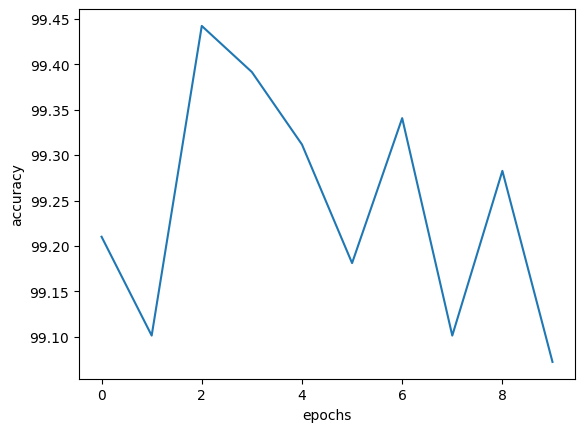

In [51]:
t,d,l,m=train_eval_loopwowandb(LSTM1,0.025747573082997077,10,128,64)
t,d,l,m
import matplotlib.pyplot as plt
ep=[]
dev_acc=[]
for i,j in enumerate(d):
    ep.append(i)
    dev_acc.append(j)
plt.plot(ep,dev_acc)
plt.xlabel('epochs')
plt.ylabel('accuracy')

In [52]:
print(t,l,d,m)

[93.03091238861289, 99.29619115211734, 99.41447835344216, 99.53177982808927, 99.5514943616434, 99.58796624871856, 99.63330967589307, 99.63528112924848, 99.60866650895039, 99.5938806087848] [15.849415797740221, 1.6125377584248781, 1.249358857050538, 0.9565173196606338, 0.8946018102578819, 0.8085333588533103, 0.7195052751339972, 0.72135806735605, 0.732833138667047, 0.7484175327699631] [99.21014492753623, 99.10144927536231, 99.44202898550725, 99.3913043478261, 99.31159420289855, 99.18115942028986, 99.34057971014492, 99.10144927536231, 99.28260869565217, 99.07246376811594] LSTM1(
  (embedding): Embedding(867, 128, padding_idx=0)
  (lstm): LSTM(128, 64, num_layers=2, batch_first=True, bidirectional=True)
  (linear2): Linear(in_features=128, out_features=14, bias=True)
)


**Using type 2 model as unidirectional GRU**

In [53]:
class LSTM2(torch.nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,output_labels_size):
        super(LSTM2,self).__init__()
        self.embedding=nn.Embedding(vocab_size,embedding_dim,padding_idx=0)
        self.lstm=nn.GRU(embedding_dim,hidden_dim,num_layers=1,bidirectional=False,batch_first=True)
        self.linear1=nn.Linear(hidden_dim*1,out_features=output_labels_size)
        #self.linear2=nn.Linear(3000,output_labels_size)
        self.lrelu=nn.LeakyReLU()
    def forward(self,id_data):
        x=self.embedding(id_data)
        x,o_t=self.lstm(x)
        x=self.linear1(x)
        #x=self.linear2(x)
        return x

In [54]:
t2,d2,l2,m2=train_eval_loopwowandb(LSTM2,0.085747573082997077,10,64,32)

Validation: 100%|██████████| 9/9 [00:00<00:00, 412.64it/s]


In [55]:
t2,d2,l2,m2

([94.4227584575349,
  98.4790237362984,
  98.65546881160792,
  98.70179796546013,
  98.67616907183977,
  98.62688273795442,
  98.60125384433404,
  98.60519675104487,
  98.47508082958757,
  98.58942512420157],
 [98.21014492753623,
  98.41304347826087,
  98.15217391304348,
  98.31884057971014,
  98.20289855072464,
  98.14492753623189,
  97.92753623188406,
  97.81884057971014,
  98.32608695652173,
  98.28985507246377],
 [13.215253127273172,
  2.8740539317950606,
  2.5058792318450287,
  2.3605035599321127,
  2.4846069365739822,
  2.465303502045572,
  2.5816057212650776,
  2.787492362782359,
  3.1067572478204966,
  2.9071404580026865],
 LSTM2(
   (embedding): Embedding(867, 64, padding_idx=0)
   (lstm): GRU(64, 32, batch_first=True)
   (linear1): Linear(in_features=32, out_features=14, bias=True)
   (lrelu): LeakyReLU(negative_slope=0.01)
 ))

Text(0, 0.5, 'accuracy')

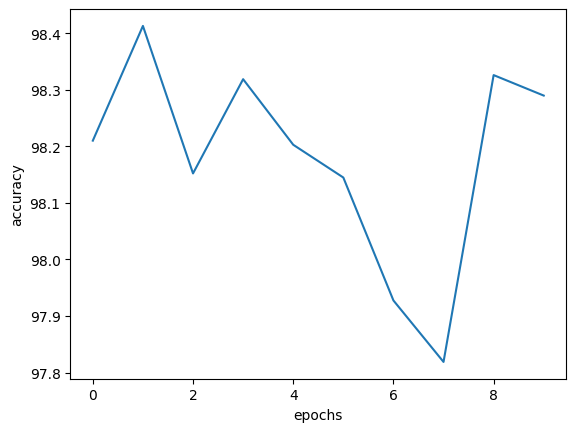

In [56]:
plt.plot(ep,d2)
plt.xlabel('epochs')
plt.ylabel('accuracy')

**Using Unidirectional barebone RNN as 3rd Model**

In [57]:
class LSTM3(torch.nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,output_labels_size):
        super(LSTM3,self).__init__()
        self.embedding=nn.Embedding(vocab_size,embedding_dim,padding_idx=0)
        self.lstm=nn.RNN(embedding_dim,hidden_dim,num_layers=1,bidirectional=False,batch_first=True)
        self.linear1=nn.Linear(hidden_dim*1,out_features=output_labels_size)
        #self.linear2=nn.Linear(3000,output_labels_size)
        #self.lrelu=nn.LeakyReLU()
    def forward(self,id_data):
        x=self.embedding(id_data)
        x,o_t=self.lstm(x)
        x=self.linear1(x)
        #x=self.linear2(x)
        return x

In [58]:
t3,d3,l3,m3=train_eval_loopwowandb(LSTM3,0.065747573082997077,10,32,128)

Validation: 100%|██████████| 9/9 [00:00<00:00, 390.91it/s]


In [59]:
t3,d3,l3,m3

([65.81105591041715,
  97.0300055200694,
  98.2759640406908,
  98.63575427805378,
  98.71264095891492,
  98.63476855137607,
  98.75207002602319,
  98.77474173961043,
  98.79642772652,
  98.72841258575822],
 [95.23913043478261,
  98.0072463768116,
  98.3695652173913,
  98.41304347826087,
  98.45652173913044,
  98.58695652173913,
  98.3768115942029,
  98.05072463768116,
  98.3623188405797,
  98.35507246376811],
 [96.42023333907127,
  8.589140895754099,
  3.926302609965205,
  2.7681601122021675,
  2.507193623110652,
  2.537336353911087,
  2.2794288024306297,
  2.0781366024166346,
  2.0338826309889555,
  2.2721001878380775],
 LSTM3(
   (embedding): Embedding(867, 32, padding_idx=0)
   (lstm): RNN(32, 128, batch_first=True)
   (linear1): Linear(in_features=128, out_features=14, bias=True)
 ))

Text(0, 0.5, 'accuracy')

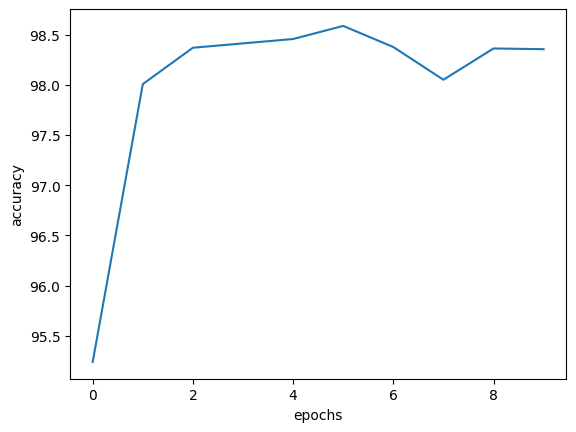

In [60]:
plt.plot(ep,d3)
plt.xlabel('epochs')
plt.ylabel('accuracy')

In [61]:
torch.save(m,'/kaggle/working/model1_2')
torch.save(m2,'/kaggle/working/model2_2')
torch.save(m3,'/kaggle/working/model3_2')

In [62]:
from sklearn.metrics import f1_score,recall_score,confusion_matrix

In [63]:
def getrecallandf1(model):
    model=torch.load(model)
    model.to(device)
    #optimizer=torch.optim.Adam(model.parameters(),learning_rate)
    #loss_fn=torch.nn.CrossEntropyLoss()
    #wandb.watch(model,loss_fn,log="all")
    true_labels_dev=[]
    predicted_labels_dev=[]
    true_labels_test=[]
    predicted_labels_test=[]
    model.eval()
    for batch in tqdm(dev_dataloader,desc='Validation'):
        with torch.no_grad():
            d,l=batch
            pred=model(d.to(device))
            #loss=loss_fn(pred.view(pred.size()[0],pred.size()[2],pred.size()[1]),l.to(device))
            _,pred_indices=torch.max(pred,2)
            #pred_indices=pred_indices.cpu().detach().numpy()
            true_labels_dev.extend(l.view(-1).cpu().detach().numpy())
            predicted_labels_dev.extend(pred_indices.view(-1).cpu().detach().numpy())
            #total_samples_dev+= l.size(0)*l.size(1)
            #loss.backward()
            #lstm1_optimizer.step()
            #dev_loss+=loss.item()
    f1_score_micro_dev=f1_score(true_labels_dev,predicted_labels_dev,average='micro')
    f1_score_macro_dev=f1_score(true_labels_dev,predicted_labels_dev,average='macro')
    recall_dev=recall_score(true_labels_dev,predicted_labels_dev,average='micro')
    confusion_matrix_dev=confusion_matrix(true_labels_dev,predicted_labels_dev)
    for batch in tqdm(test_dataloader,desc='testing'):
        with torch.no_grad():
            d,l=batch
            pred=model(d.to(device))
            #loss=loss_fn(pred.view(pred.size()[0],pred.size()[2],pred.size()[1]),l.to(device))
            _,pred_indices=torch.max(pred,2)
            #pred_indices=pred_indices.cpu().detach().numpy()
            true_labels_test.extend(l.view(-1).cpu().detach().numpy())
            predicted_labels_test.extend(pred_indices.view(-1).cpu().detach().numpy())
            #total_samples_dev+= l.size(0)*l.size(1)
            #loss.backward()
            #lstm1_optimizer.step()
            #dev_loss+=loss.item()
    f1_score_micro_test=f1_score(true_labels_test,predicted_labels_test,average='micro')
    f1_score_macro_test=f1_score(true_labels_test,predicted_labels_test,average='macro')
    recall_test=recall_score(true_labels_test,predicted_labels_test,average='micro')
    confusion_matrix_test=confusion_matrix(true_labels_test,predicted_labels_test)
    #dev_epoch_acc.append(acc_d)
    return f1_score_micro_dev,f1_score_macro_test,recall_dev,f1_score_micro_test,f1_score_macro_test,recall_test,confusion_matrix_dev,confusion_matrix_test

In [66]:
f1_mi_1_dev,f1_ma_1_dev,re_1_dev,f1_mi_1_test,f1_ma_1_test,re_1_test,confusion_matrix_dev_1,confusion_matrix_test1=getrecallandf1('/kaggle/working/model1_2')

testing: 100%|██████████| 9/9 [00:00<00:00, 95.29it/s]


In [65]:
## Dev Stats for Model 1:


In [67]:
f1_mi_1_dev,f1_ma_1_dev,re_1_dev,confusion_matrix_dev_1

(0.9907246376811594,
 0.9613568788045838,
 0.9907246376811594,
 array([[7278,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0],
        [   4, 1539,    0,    1,    0,    0,    0,    0,    1,    2,    0,
            0,    0,    0],
        [   0,    0, 1422,    0,    0,    0,    3,    0,    1,    0,    0,
            2,    1,    0],
        [   0,    6,    0, 1147,    1,    0,    0,    0,    1,    1,    0,
            0,    0,    0],
        [   0,    1,   23,    3,  589,    0,    1,    1,    3,    0,    0,
            3,    0,    0],
        [   0,    0,    1,    0,    0,  503,    4,    0,    0,    0,    0,
            1,    0,    0],
        [   0,    0,    1,    0,    0,    0,  385,    0,    0,    1,    0,
            0,    0,    0],
        [   0,    0,    0,    0,    3,    0,    0,  248,    1,    0,    0,
            0,    0,    0],
        [   0,    2,    0,    1,    0,    0,    0,    0,  211,    1,    0,
            3,    0,    0],
        [ 

In [68]:
f1_mi_1_test ,f1_ma_1_test, re_1_test ,confusion_matrix_test1

(0.9889035861258083,
 0.9613568788045838,
 0.9889035861258083,
 array([[7030,    1,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0],
        [   2, 1528,    2,    5,    0,    0,    0,    0,    0,    0,    0,
            1,    0,    0],
        [   0,    0, 1399,    0,    0,    0,    3,    0,    0,    0,    0,
            2,    3,    0],
        [   2,    9,    0, 1111,    2,    0,    0,    0,    1,    0,    0,
            3,    0,    0],
        [   0,    0,   20,    2,  619,    0,    1,    1,    2,    1,    0,
            1,    0,    0],
        [   0,    0,   16,    0,    0,  533,   14,    0,    0,    0,    0,
            0,    0,    0],
        [   0,    0,    0,    0,    0,    0,  407,    0,    0,    0,    0,
            1,    0,    0],
        [   0,    0,    0,    0,   11,    0,    0,  250,    0,    0,    0,
            0,    0,    0],
        [   0,    2,    0,   10,    0,    0,    0,    0,  208,    0,    0,
            7,    0,    0],
        [ 

***train dev test sentences s=2,p=3***

In [168]:
class Datafetchq1(Dataset):
    def __init__(self,type_of_data,p,s):
        data=[]
        labels=[]
        for x in tqdm(parse_incr(io.open(type_of_data)),desc='Generate words and tokens'):
            if len(x)<p+s+1 :continue
            for i in range(0,len(x)):
                if i+p+s+1<=len(x):
                    pre_context=[vocab_data[i['form']] for i in x[i:p+i]]
                    word=vocab_data[x[p+i]['form']]
                    label=vocab_labels[x[p+i]['upos']]
                    post_context=[vocab_data[i['form']] for i in x[p+i+1:s+i+p+1]]
                    data.append(pre_context+[word]+post_context)
                    labels.append(label)
        self.data=tensor(data)
        self.labels=tensor(labels)
    def __len__(self)->int:
        return len(self.data)
    def __getitem__(self,index:int):
        return self.data[index],self.labels[index]
            
        
        

In [70]:
train_dataset_q1=Datafetchq1(all_files_loc[0],2,3)

Generate words and tokens: 4274it [00:01, 3282.30it/s]


In [71]:
train_dataloader_q1=DataLoader(train_dataset_q1,256,shuffle=True,pin_memory=True)

In [123]:
dev_dataset_q1=Datafetchq1(all_files_loc[1],2,3)
dev_dataloader_q1=DataLoader(dev_dataset_q1,256,shuffle=True,pin_memory=True)

Generate words and tokens: 586it [00:00, 4301.89it/s]


In [124]:
d,l=next(iter(train_dataloader_q1))

In [125]:
d,l=next(iter(dev_dataloader_q1))

In [126]:
d.shape,l.shape

(torch.Size([256, 6]), torch.Size([256]))

In [127]:
class MLP1(torch.nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,output_labels_size):
        super(MLP1,self).__init__()
        self.embedding=nn.Embedding(vocab_size,embedding_dim,padding_idx=0)
        self.embedding.weight.requires_grad=True
        self.linear1=nn.Linear(embedding_dim,hidden_dim)
        #self.linear1=nn.Linear(hidden_dim*2,out_features=384)
        self.linear2=nn.Linear(hidden_dim,output_labels_size)
        self.lrelu=nn.LeakyReLU()
    def forward(self,id_data):
        x=self.embedding(id_data)
        x=x.mean(dim=1)
        x=self.lrelu(self.linear1(x))
        x=self.linear2(x)
        return x

In [128]:
MLP1(len(vocab_data),64,64,len(vocab_labels))

MLP1(
  (embedding): Embedding(867, 64, padding_idx=0)
  (linear1): Linear(in_features=64, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=14, bias=True)
  (lrelu): LeakyReLU(negative_slope=0.01)
)

In [149]:
def train_eval_loopwowandbq1(model,learning_rate,epochs,embedding_dim,hidden_units):
    model=model(len(vocab_data),embedding_dim,hidden_units,len(vocab_labels))
    model.to(device)
    optimizer=torch.optim.Adam(model.parameters(),learning_rate)
    loss_fn=torch.nn.CrossEntropyLoss()
    #wandb.watch(model,loss_fn,log="all")
    train_epoch_acc=[]
    dev_epoch_acc=[]
    running_loss_train=[]
    running_loss_dev=[]
    for i in range(epochs):
        model.train()
        train_correct=0
        dev_correct=0
        total_samples_train=0
        total_samples_dev=0
        running_loss=0.0
        acc_t=0
        acc_d=0
        for batch in tqdm(train_dataloader_q1,desc='training'):
            d,l=batch
            optimizer.zero_grad()
            pred=model(d.to(device))
           # print(pred.shape,l.shape)
            loss=loss_fn(pred,l.to(device))
            loss.backward()
            optimizer.step()
            _,pred_indices=torch.max(pred,1)
            train_correct+=(pred_indices.view(-1)==l.view(-1).to(device)).sum().item()
            total_samples_train+= l.size(0)
            running_loss+=loss.item()
            #    wandb.log({'epoch':i+1,'loss':running_loss})
        acc_t=100*train_correct/total_samples_train
        running_loss_train.append(running_loss)
        train_epoch_acc.append(acc_t)
        model.eval()
        for batch in tqdm(dev_dataloader_q1,desc='Validation'):
            with torch.no_grad():
                d,l=batch
                pred=model(d.to(device))
                loss=loss_fn(pred,l.to(device))
                _,pred_indices=torch.max(pred,1)
                        #pred_indices=pred_indices.cpu().detach().numpy()
                dev_correct+=(pred_indices.view(-1)==l.view(-1).to(device)).sum().item()
                total_samples_dev+= l.size(0)
                        #loss.backward()
                        #lstm1_optimizer.step()
                        #dev_loss+=loss.item()
        acc_d=100*dev_correct/total_samples_dev
        dev_epoch_acc.append(acc_d)
    return train_epoch_acc,dev_epoch_acc,running_loss_train,model

In [136]:
tr_ep_acc,dev_ep_acc,loss,model_q1=train_eval_loopwowandbq1(MLP1,0.00876,10,128,512)

Validation: 100%|██████████| 15/15 [00:00<00:00, 466.15it/s]


In [137]:
tr_ep_acc,dev_ep_acc,loss,model_q1

([53.19296200502714,
  67.3490947506466,
  72.75144803467998,
  76.98444501111071,
  79.89872864376525,
  83.00608356708317,
  85.66536738188044,
  87.29736621616699,
  89.0422935412189,
  90.142435612546],
 [61.91639522258415,
  69.86970684039088,
  71.47122692725299,
  73.0456026058632,
  75.1085776330076,
  75.4071661237785,
  75.7871878393051,
  75.1628664495114,
  75.0814332247557,
  74.8371335504886],
 [134.88248759508133,
  94.52569681406021,
  78.30268913507462,
  66.44669479131699,
  57.51997837424278,
  49.21497970819473,
  41.74163976311684,
  37.06970039010048,
  32.60220219194889,
  29.719360679388046],
 MLP1(
   (embedding): Embedding(867, 128, padding_idx=0)
   (linear1): Linear(in_features=128, out_features=512, bias=True)
   (linear2): Linear(in_features=512, out_features=14, bias=True)
   (lrelu): LeakyReLU(negative_slope=0.01)
 ))

In [138]:
train_dataset_q1=Datafetchq1(all_files_loc[0],3,3)
train_dataloader_q1=DataLoader(train_dataset_q1,256,shuffle=True,pin_memory=True)

Generate words and tokens: 4274it [00:01, 4260.95it/s]


In [139]:
dev_dataset_q1=Datafetchq1(all_files_loc[1],3,3)
dev_dataloader_q1=DataLoader(dev_dataset_q1,256,shuffle=True,pin_memory=True)

Generate words and tokens: 586it [00:00, 4269.23it/s]


In [155]:
len(train_dataloader_q1)

92

In [151]:
class MLP2(torch.nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,output_labels_size):
        super(MLP2,self).__init__()
        self.embedding=nn.Embedding(vocab_size,embedding_dim,padding_idx=0)
        self.embedding.weight.requires_grad=True
        self.linear1=nn.Linear(embedding_dim*7,hidden_dim)
        #self.linear1=nn.Linear(hidden_dim*2,out_features=384)
        self.linear2=nn.Linear(hidden_dim,output_labels_size)
        self.lrelu=nn.LeakyReLU()
    def forward(self,id_data):
        x=self.embedding(id_data)
        x=self.lrelu(self.linear1(x.view(x.size(0),-1)))
        x=self.linear2(x)
        return x

In [152]:
tr_ep_acc_2,dev_ep_acc_2,loss_2,model2_q1=train_eval_loopwowandbq1(MLP2,0.02,10,128,128)

Validation: 100%|██████████| 13/13 [00:00<00:00, 434.79it/s]


In [153]:
tr_ep_acc_2,dev_ep_acc_2,model2_q1

([92.7210593763349,
  98.13754805638617,
  98.50918410935498,
  98.34686031610423,
  98.00939769329347,
  98.00939769329347,
  98.45365228534814,
  98.65014950875694,
  98.53054250320376,
  98.79965826569843],
 [96.90491384811742,
  97.41544352265475,
  97.16017868538609,
  97.319719208679,
  96.7453733248245,
  96.87300574345883,
  97.92597319719209,
  97.86215698787493,
  97.73452456924059,
  96.96873005743458],
 MLP2(
   (embedding): Embedding(867, 128, padding_idx=0)
   (linear1): Linear(in_features=896, out_features=128, bias=True)
   (linear2): Linear(in_features=128, out_features=14, bias=True)
   (lrelu): LeakyReLU(negative_slope=0.01)
 ))

In [172]:
class MLP3(torch.nn.Module):
    def __init__(self,vocab_size,embedding_dim,hidden_dim,output_labels_size):
        super(MLP3,self).__init__()
        self.embedding=nn.Embedding(vocab_size,embedding_dim,padding_idx=0)
        self.embedding.weight.requires_grad=True
        self.linear1=nn.Linear(embedding_dim*9,hidden_dim)
        #self.linear1=nn.Linear(hidden_dim*2,out_features=384)
        self.linear2=nn.Linear(hidden_dim,output_labels_size)
        self.lrelu=nn.LeakyReLU()
    def forward(self,id_data):
        x=self.embedding(id_data)
        #print(x.shape)
        x=self.lrelu(self.linear1(x.view(x.size(0),-1)))
        x=self.linear2(x)
        return x

In [177]:
train_dataset_q1=Datafetchq1(all_files_loc[0],4,4)
train_dataloader_q1=DataLoader(train_dataset_q1,256,shuffle=True,pin_memory=True)
dev_dataset_q1=Datafetchq1(all_files_loc[1],4,4)
dev_dataloader_q1=DataLoader(dev_dataset_q1,256,shuffle=True,pin_memory=True)
test_dataset_q1=Datafetchq1(all_files_loc[2],4,4)
test_dataloader_q1=DataLoader(test_dataset_q1,256,shuffle=True,pin_memory=True)

Generate words and tokens: 4274it [00:00, 4276.98it/s]
Generate words and tokens: 586it [00:00, 4515.10it/s]
Generate words and tokens: 572it [00:00, 4272.55it/s]


In [174]:
tr_ep_acc_3,dev_ep_acc_3,loss_2,model2_q1=train_eval_loopwowandbq1(MLP3,0.00897,10,64,128)

Validation: 100%|██████████| 9/9 [00:00<00:00, 527.53it/s]


In [175]:
tr_ep_acc_3,dev_ep_acc_3,loss_2,model2_q1

([85.73309920983318,
  97.41000877963126,
  99.18474852627618,
  99.64881474978051,
  99.80559387934278,
  99.8620343659852,
  99.89339019189765,
  99.91847485262763,
  99.92474601781011,
  99.95610184372256],
 [93.80028395646,
  95.55134879318504,
  96.02460955986749,
  95.929957406531,
  96.21391386654047,
  96.30856601987695,
  96.35589209654519,
  96.40321817321345,
  96.68717463322291,
  96.63984855655467],
 [31.01949042081833,
  5.486823353916407,
  1.7365488889627159,
  0.9377059651305899,
  0.5322883530170657,
  0.3577984158473555,
  0.2883080125611741,
  0.18638406274840236,
  0.18002150263055228,
  0.09061714880226646],
 MLP3(
   (embedding): Embedding(867, 64, padding_idx=0)
   (linear1): Linear(in_features=576, out_features=128, bias=True)
   (linear2): Linear(in_features=128, out_features=14, bias=True)
   (lrelu): LeakyReLU(negative_slope=0.01)
 ))

In [180]:
model3_q1=model2_q1

In [181]:
torch.save(model3_q1,'/kaggle/working/model3q1')

In [176]:
##Best performing is Model 3 

In [183]:
def getrecallandf1_q1(model):
    model=torch.load(model)
    model.to(device)
    #optimizer=torch.optim.Adam(model.parameters(),learning_rate)
    #loss_fn=torch.nn.CrossEntropyLoss()
    #wandb.watch(model,loss_fn,log="all")
    true_labels_dev=[]
    predicted_labels_dev=[]
    true_labels_test=[]
    predicted_labels_test=[]
    model.eval()
    for batch in tqdm(dev_dataloader_q1,desc='Validation'):
        with torch.no_grad():
            d,l=batch
            pred=model(d.to(device))
            #loss=loss_fn(pred.view(pred.size()[0],pred.size()[2],pred.size()[1]),l.to(device))
            _,pred_indices=torch.max(pred,1)
            #pred_indices=pred_indices.cpu().detach().numpy()
            true_labels_dev.extend(l.view(-1).cpu().detach().numpy())
            predicted_labels_dev.extend(pred_indices.view(-1).cpu().detach().numpy())
            #total_samples_dev+= l.size(0)*l.size(1)
            #loss.backward()
            #lstm1_optimizer.step()
            #dev_loss+=loss.item()
    f1_score_micro_dev=f1_score(true_labels_dev,predicted_labels_dev,average='micro')
    f1_score_macro_dev=f1_score(true_labels_dev,predicted_labels_dev,average='macro')
    recall_dev=recall_score(true_labels_dev,predicted_labels_dev,average='micro')
    confusion_matrix_dev=confusion_matrix(true_labels_dev,predicted_labels_dev)
    for batch in tqdm(test_dataloader_q1,desc='testing'):
        with torch.no_grad():
            d,l=batch
            pred=model(d.to(device))
            #loss=loss_fn(pred.view(pred.size()[0],pred.size()[2],pred.size()[1]),l.to(device))
            _,pred_indices=torch.max(pred,1)
            #pred_indices=pred_indices.cpu().detach().numpy()
            true_labels_test.extend(l.view(-1).cpu().detach().numpy())
            predicted_labels_test.extend(pred_indices.view(-1).cpu().detach().numpy())
            #total_samples_dev+= l.size(0)*l.size(1)
            #loss.backward()
            #lstm1_optimizer.step()
            #dev_loss+=loss.item()
    f1_score_micro_test=f1_score(true_labels_test,predicted_labels_test,average='micro')
    f1_score_macro_test=f1_score(true_labels_test,predicted_labels_test,average='macro')
    recall_test=recall_score(true_labels_test,predicted_labels_test,average='micro')
    confusion_matrix_test=confusion_matrix(true_labels_test,predicted_labels_test)
    #dev_epoch_acc.append(acc_d)
    return f1_score_micro_dev,f1_score_macro_test,recall_dev,f1_score_micro_test,f1_score_macro_test,recall_test,confusion_matrix_dev,confusion_matrix_test

In [184]:
f1_score_micro_dev,f1_score_macro_test,recall_dev,f1_score_micro_test,f1_score_macro_test,recall_test,confusion_matrix_dev,confusion_matrix_test=getrecallandf1_q1('/kaggle/working/model3q1')

testing: 100%|██████████| 9/9 [00:00<00:00, 393.55it/s]


In [185]:
f1_score_micro_dev,f1_score_macro_test,recall_dev,f1_score_micro_test,f1_score_macro_test,recall_test,confusion_matrix_dev,confusion_matrix_test

(0.9663984855655466,
 0.8858125137916658,
 0.9663984855655466,
 0.957765068191817,
 0.8858125137916658,
 0.957765068191817,
 array([[588,   3,   4,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  1, 652,   0,   0,   0,   2,   0,   0,   0,   0,   0,   1,   0],
        [  3,   0, 346,   2,   1,   2,   0,   0,   0,   0,   0,   0,   0],
        [  0,   1,   6, 164,   1,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   2,   1,   0,  87,   1,   0,   1,   0,   0,   0,   0,   0],
        [  0,   1,   1,   0,   3,  21,   0,   0,   1,   0,   0,   0,   0],
        [  0,   2,   1,   2,   0,   0,  21,   0,   0,   0,   0,   0,   0],
        [  2,   1,   1,   1,   0,   0,   0,  61,   1,   0,   0,   0,   0],
        [  3,   0,   1,   1,   0,   0,   1,   1,  33,   0,   0,   0,   0],
        [  1,   0,   1,   0,   0,   0,   0,   1,   0,  53,   0,   0,   0],
        [  3,   1,   1,   0,   0,   1,   0,   1,   0,   0,   3,   0,   0],
        [  0,   2,   0,   0,   0,   0,   0,   0,   